[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/chubbj/lab_scripts/blob/main/notebooks/circular_dichroisim_analysis.ipynb)


# Code for anyalysing Circular Dichroism data

This code executes data parsing for CD signal (mdeg) as a function of wavelength (nm).

## What this notebook includes

- Parsing raw CD TXT files into dataframes
- Transforming CD signal to MRE
- Visualisation of CD spectrum and variable temperature data
- Estimation of transition temperatures

## What this notebook does not include

- Secondary structure deconvolution

## Todo

- [ ] Batch mode?

In [3]:
#@title # Setup

#@markdown This cell import all the necessary code required from other modules
#@markdown and defines custom functions.

#@markdown **RUN THIS FIRST!**

# standard
import re
from pathlib import Path

# external
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.optimize import curve_fit
from matplotlib.ticker import ScalarFormatter
from sklearn.metrics import r2_score, mean_squared_error

from google.colab import drive

# custom functions
split_filePaths = lambda filePath: list(map(Path, filePath.split(","))) if "," in filePath else [Path(filePath)]

def parse_data(dataPath:Path, numAmides:int, protConc:float, pathLength:float) -> pd.DataFrame:

    dataStr = dataPath.read_text()

    # extract X-axis and format
    xPattern = re.compile(r"XUNITS\s+(\w+)(?:\s*\[([\w]+)\])?")
    xLabel = re.search(xPattern, dataStr).groups()
    xLabel = xLabel[0].lower() + ("_" + xLabel[1] if xLabel[1] is not None else "")

    # extract Y-axes and format
    yPattern = re.compile(r"Y\d*UNITS\s+(\w+)(?:\s*\[([\w]+)\])?")
    yLabels = re.findall(yPattern, dataStr)
    yLabels = ["_".join(y).lower() if len(y[1]) > 0  else y[0].lower() for y in yLabels]

    dataDict = {
        "file_name":dataPath.stem,
        xLabel: [],
    }

    for yLabel in yLabels:
        dataDict[yLabel] = []

    start = False
    for line in dataStr.splitlines():

        if start:
            line_split = line.split("\t")
            if len(line_split) == len(yLabels) +1: # + 1 for x-axis
                dataDict[xLabel].append(float(line_split[0]))

                for n, yLabel in enumerate(yLabels, start=1):
                    dataDict[yLabel].append(float(line_split[n]))
            else:
                break

        if line.startswith("XYDATA"):
            start=True

    dataDict["num_amides"] = numAmides
    dataDict["conc_M"] = protConc
    dataDict["pathlength_cm"] = pathLength

    return pd.DataFrame(dataDict)

def calculate_mre(cd_mdeg_blank, pathlength_cm, num_amides, conc_M):
    """
    Calculate Mean Residue Ellipticity (MRE).

    Formula reference: https://www.photophysics.com/faqs/methods-techniques/cd-units-faqs/
    Units: deg cm^2 dmol^-1 res^-1

    Parameters:
        cd_mdeg_blank (pd.Series): CD signal in millidegrees (after blank correction)
        pathlength_cm (float or pd.Series): Pathlength in cm
        num_amides (int or pd.Series): Number of amide bonds (residues - 1)
        conc_M (float or pd.Series): Concentration in molarity (M)

    Returns:
        pd.Series: MRE values
    """
    # convert millidegrees to degrees
    cd_deg_blank = cd_mdeg_blank / 1000
    mean_residue_concentration = num_amides * conc_M
    return 100 * cd_deg_blank / (pathlength_cm * mean_residue_concentration)

def plotData(spectrumPlot, spectrumData, x_loc:int, y_loc:int, showHT:bool, toFit:bool=False):

    x = spectrumData.columns[x_loc]
    xlabel = "Wavelength (nm)" if x == "nanometers" else r"Temperature ($\circ$C)"
    y = spectrumData.columns[y_loc]
    if y == "mre":
        ylabel = r"MRE (deg cm$^2$ / dmol)"
    elif y == "ht_v":
        ylabel = "HT (V)"
    else:
        ylabel = "Absorbance (AU)"

    if showHT:
        # get the wavelength where HT exceeds 600 V
        highHT = spectrumData.loc[spectrumData["ht_v"] >= 600, x].max()

        # denote region of HT > 600 V
        spectrumPlot.axvspan(spectrumData[x].min(), highHT, facecolor=".8")

    # Plot MRE spectrum
    if toFit:
        spectrumData = predict_Tm(spectrumData, sigmoid)

        sns.scatterplot(
            data=spectrumData,
            x=x,
            y=y,
            ax=spectrumPlot,
            hue="file_name",
            legend=False,
            alpha=0.3
        )
        sns.lineplot(
            data=spectrumData,
            x=x,
            y='ypred',
            ax=spectrumPlot,
            hue="file_name",
            legend=False,
        )

    else:

        sns.lineplot(
            data=spectrumData,
            x=x,
            y=y,
            ax=spectrumPlot,
            hue="file_name",
            legend=False
        )

    # Set plot aesthetics
    spectrumPlot.set(
        xlim=(spectrumData[x].min(), spectrumData[x].max()),
        xlabel=xlabel
    )

    spectrumPlot.set_ylabel(ylabel)

    if ylabel == "MRE (deg cm$^2$ / dmol)":
        # Format y-axis
        spectrumPlot.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        spectrumPlot.ticklabel_format(axis='y', style='scientific', scilimits=(-2, 2))

# Simple sigmoid function
def sigmoid(x, L, x0, k, b):
    return L / (1 + np.exp(-k * (x - x0))) + b

def predict_Tm(dataFrame, fx):

    for fileName in dataFrame['file_name'].unique():
        # Get data for each file
        fileData = dataFrame[dataFrame['file_name'] == fileName]

        # Fit the function
        popt, pcov = curve_fit(fx, fileData['temperature_C'], fileData['mre'], p0=[max(fileData['mre']), np.median(fileData['temperature_C']), 1, min(fileData['mre'])], maxfev=1_000_000)
        ypred = fx(fileData['temperature_C'], *popt)

        dataFrame.loc[dataFrame['file_name'] == fileName, 'ypred'] = ypred

        # Calculate R-squared and RMSE
        perr = np.sqrt(np.diag(pcov))
        r2 = r2_score(dataFrame['mre'], ypred)
        rmse = np.sqrt(mean_squared_error(dataFrame['mre'], ypred))

        # Calculate Pearson correlation between residuals and temperature
        residuals = dataFrame['mre'] - ypred
        correlation, p_value = pearsonr(residuals, dataFrame['temperature_C'])

        # print fitting summary
        print(f"###### Fitting summary for {fileName} #####\n")
        print(f"Fit parameters: L = {popt[0]:.2f} ± {perr[0]:.2f}, x0 = {popt[1]:.2f} ± {perr[1]:.2f}, k = {popt[2]:.2f} ± {perr[2]:.2f}, b = {popt[3]:.2f} ± {perr[3]:.2f}")
        print(f"R-squared Score: {r2:.4f}")  # Closer to 1 means a better fit
        print(f"RMSE: {rmse:.4f}")

        if abs(popt[1]-dataFrame['temperature_C'].max()) < 20:
            print(f"WARNING: Fitted Tm is less than 15°C away from the max temperature in the data. This suggests incomplete transition and parameter extrapolation.")
        if popt[0] > 0:
            print(f"WARNING: Fully unfolded state (L) has positive MRE! This suggests incomplete transition and parameter extrapolation.")
        if abs(correlation) > 0.1 and p_value < 0.05:
            print("WARNING: Reisduals show a correlation with temperature, this suggest a systematic error in the data. Check the fit, disregard parameters if necessary.")
        print(f"\n######\n")

    return dataFrame


In [4]:
#@title # Set up drive for data import

#@markdown - Provide the file path to your baseline file:
mountDrive = True #@param {type:"boolean"}
if mountDrive:
    drive.mount("/content/drive")

#@markdown **If you don't mount your Gdrive, upload files to the working directory.**

Mounted at /content/drive


In [16]:
#@title #Parse spectrum data

#@markdown - Provide the file path to your baseline file:
blankPath = "" #@param {type:"string", placeholder: "path/to/blank/file(s).txt"}

#@markdown - Provide the file path to your sample file:
spectrumPath = "" #@param {type:"string", placeholder: "path/to/sample/file(s).txt"}

#@markdown - Provide the directory path to save the data, leave blank if you don't want to save transformed data:
savePath = "" #@param {type:"string", placeholder: "path/to/save/data.csv"}

#@markdown - 0-indexed pairs of blank and sample files to blank in the order provided. Use `:` to seperate blank-sample file pairs. E.g. "0,0:1,1" will use blank file 0 with sample file 0 and blank file 1 with sample file 1.
#@markdown If you don't have a blank for a piece of data, pass an empty string `""`. E.g. I have a blank for the first file but not the second: "0,0:,1"
blank_sample_paris = "0,0" #@param {type:"string"}

#@markdown ## Sample information

#@markdown - How many amides are present (length of sequence - 1, unless chemical modified e.g. Acetyl group), use comma to denote mulitple samples:
numAmides =  "100" #@param {type:"string"}

#@markdown - Protein concentration (M), use comma to denote mulitple samples:
protConc =  "10e-6" #@param {type:"string"}

#@markdown - Cuvette pathlength (cm), use comma to denote mulitple samples:
pathLength =  "0.1" #@param {type:"string"}

# manage variable types
blankPath = split_filePaths(blankPath) if len(blankPath) > 0 else [""]
spectrumPath = split_filePaths(spectrumPath)
blank_sample_paris = [pair.split(",") for pair in blank_sample_paris.split(":")]
blankIdx = [int(pair[0]) if pair[0] != "" else "" for pair in blank_sample_paris]
sampleIdx = [int(pair[1]) if pair[1] != "" else "" for pair in blank_sample_paris]
numAmides = list(map(int, numAmides.split(",")) if "," in numAmides else [int(numAmides)]*len(spectrumPath))
protConc = list(map(float, protConc.split(",")) if "," in protConc else [float(protConc)]*len(spectrumPath))
pathLength = list(map(float, pathLength.split(",")) if "," in pathLength else [float(pathLength)]*len(spectrumPath))

# parse each blank-sample pair and create allData
for i, (_blankIdx, _sampleIdx, _numAmides, _protConc, _pathLength) in enumerate(zip(blankIdx, sampleIdx, numAmides, protConc, pathLength)):

    # parse data
    _spectrumData = parse_data(spectrumPath[int(_sampleIdx)], _numAmides, _protConc, _pathLength)

    if _blankIdx != "":
        _blankData = parse_data(blankPath[int(_blankIdx)], 0, 0, _pathLength)

        # blank baseline from data
        _spectrumData["cd_mdeg_blank"] = _spectrumData["cd_mdeg"] - _blankData["cd_mdeg"]

        # calculate mre
        _spectrumData['mre'] = calculate_mre(
            _spectrumData["cd_mdeg_blank"],
            _spectrumData["pathlength_cm"],
            _spectrumData["num_amides"],
            _spectrumData["conc_M"]
        )

    else:
        print(f"WARNING: Calculating MRE for {spectrumPath[int(_sampleIdx)].stem} without subtracting baseline. No blank data provided.")
        # calculate mre without blank
        _spectrumData['mre'] = calculate_mre(
            _spectrumData["cd_mdeg"],
            _spectrumData["pathlength_cm"],
            _spectrumData["num_amides"],
            _spectrumData["conc_M"]
        ).round(2)

    # if first iteration, create allData
    if i == 0 and _blankIdx != "":
        allData = pd.concat([_blankData, _spectrumData], ignore_index=True)
    elif i == 0:
        allData = _spectrumData

    # if not first iteration, append data to allData
    else:

        allData = pd.concat([allData, _spectrumData], ignore_index=True)

        # add blank data only if not already in allData
        if _blankIdx != "":
            if not blankPath[_blankIdx].stem in allData["file_name"].values:
                allData = pd.concat([allData, _blankData], ignore_index=True)

# save data
if savePath != "":
    savePath = Path(savePath)
    savePath.mkdir(exist_ok=True, parents=True)
    allData.to_csv(savePath / "transformed_cd_data.csv", index=False)

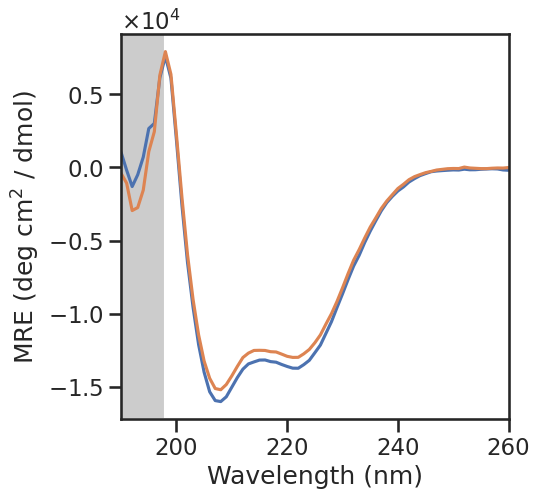

In [17]:
#@title # Visualisation options

#@markdown - In what context will you be showing this data?
plotContext = "talk" #@param ["paper", "notebook", "talk", "poster"]

#@markdown - What aspect ratio to use for the plots. If you're plotting MRE and absorbance, I would suggest setting to 2.
plotAspect = 1 #@param {type: "raw"}

#@markdown - Show HT as seperate plot, else high HT regions are denoted by greyed region.
plotHT = False #@param {type:"boolean"}

#@markdown - Show Absorbance as seperate plot.
plotAbsorbance = False #@param {type:"boolean"}
if plotAbsorbance:
    assert "absorbance" in allData.columns, "Absorbance data not present in allData."

#@markdown - Which data to plot?
toPlot = "Spectrum" # @param ["Spectrum", "Temperature"]
assert toPlot in ["Spectrum", "Temperature"], "toPlot must be either 'Spectrum' or 'Temperature'"

#@markdown - Fit melting curve to sigmoid?
toFit = False #@param {type:"boolean"}
if toFit:
    assert toPlot == "Temperature", "Fitting only works with temperature data."

#@markdown - Where to save the plot (leave empty if you don't want to save)
plotFile = "" #@param {type: "string", placeholder: "path/to/save/plot.png"}
toSave = False
if plotFile != "":
    toSave = True
    plotFile = Path(plotFile)
    plotFile.parent.mkdir(exist_ok=True, parents=True)

#@markdown - The DPI for the saved plots
plotDPI = 300 #@param {type: "raw"}

#@markdown I encourage you to play around with the code to get the plots how you like them!

#@title Data visualisation

plotHeights = {
    "paper": 3,
    "notebook": 4,
    "talk": 5,
    "poster": 7,
}

# drop any mre NaN rows (should coincide with blanks)
if toPlot == "Temperature":

    # drop rows were temperature is NaN
    data_to_plot = allData.dropna(subset=["temperature_C", "mre"])

    # get index of temperature column
    x_idx = data_to_plot.columns.get_loc("temperature_C")

else:

    # drop rows were nanometers is NaN
    data_to_plot = allData.dropna(subset=["nanometers", "mre"])

    # get index of nanometers column
    x_idx = data_to_plot.columns.get_loc("nanometers")


sns.set(style="ticks", context=plotContext, rc={"figure.figsize":[plotHeights[plotContext] * plotAspect, plotHeights[plotContext]]})

if plotHT and plotAbsorbance:

    # setup plot grid
    mrePlot = plt.subplot2grid((5,2), (0,0), rowspan=4)
    absPlot = plt.subplot2grid((5,2), (0,1), rowspan=4)
    mre_htPlot = plt.subplot2grid((5,2), (4,0))
    abs_htPlot = plt.subplot2grid((5,2), (4,1))

    # make base plots
    y1_idx = data_to_plot.columns.get_loc("mre")
    y2_idx = data_to_plot.columns.get_loc("absorbance")
    y3_idx = data_to_plot.columns.get_loc("ht_v")
    plotData(mrePlot, data_to_plot,x_idx, y1_idx, showHT=True, toFit=toFit)
    plotData(absPlot, data_to_plot,x_idx, y2_idx, showHT=True)
    plotData(mre_htPlot, data_to_plot, x_idx, y3_idx, showHT=False)
    plotData(abs_htPlot, data_to_plot, x_idx, y3_idx, showHT=False)

    # remove unnessacary labels
    mrePlot.set(xlabel="", xticklabels=[])
    absPlot.set(xlabel="", xticklabels=[])

    plt.tight_layout()

elif plotHT and not plotAbsorbance:

    # setup plot grid
    mrePlot = plt.subplot2grid((5,1), (0,0), rowspan=4)
    mre_htPlot = plt.subplot2grid((5,1), (4,0))

    # make base plots
    y1_idx = data_to_plot.columns.get_loc("mre")
    y2_idx = data_to_plot.columns.get_loc("ht_v")
    plotData(mrePlot, data_to_plot,x_idx, y1_idx, showHT=True, toFit=toFit)
    plotData(mre_htPlot, data_to_plot, x_idx, y2_idx, showHT=False)

    # remove unnessacary labels
    mrePlot.set(xlabel="", xticklabels=[])

    plt.tight_layout()

elif plotAbsorbance:

    # setup plot grid
    mrePlot = plt.subplot2grid((1,2), (0,0))
    absPlot = plt.subplot2grid((1,2), (0,1))

    # make base plots
    y1_idx = data_to_plot.columns.get_loc("mre")
    y2_idx = data_to_plot.columns.get_loc("absorbance")
    plotData(mrePlot, data_to_plot,x_idx, y1_idx, showHT=True, toFit=toFit)
    plotData(absPlot, data_to_plot,x_idx, y2_idx, showHT=True)

    plt.tight_layout()

else:

    # setup plot grid
    mrePlot = plt.subplot2grid((1,1), (0,0))

    # make base plot
    y_idx = data_to_plot.columns.get_loc("mre")
    plotData(mrePlot, data_to_plot,x_idx, y_idx, showHT=True, toFit=toFit)

plt.savefig(plotFile, dpi=plotDPI) if toSave else None
plt.show()
